In [2]:
from ladybug.epw import EPW
import numpy as np
from ladybug.dt import DateTime, datetime
import pandas as pd
from datetime import timezone, timedelta, tzinfo, timezone

# load test data from a file
epw_file = (r"C:\Users\tgerrish\Documents\GitHub\target_dir\kvrrj\tests\assets\example.epw")
epw = EPW(epw_file)


In [94]:
from kvrrj.solar2 import Solar

sol = Solar.from_epw(epw)

# Solar.from_dict(sol.to_dict())

# Solar.from_json(sol.to_json())

# Solar.from_dataframe(sol.to_dataframe())

# sol.ghi.mean(), (sol * 2).ghi.mean()
# (sum([sol, sol, sol]) / 3).ghi.mean(), sol.ghi.mean()


Solar.from_average([sol, sol, sol], weights=[-1, 2, 3]).ghi.mean(), sol.ghi.mean()

(np.float64(115.24417808219178), np.float64(115.24417808219178))

In [79]:
from kvrrj.solar2 import Solar, Sunpath, Sun

sp = Sunpath.from_location(epw.location)
suns = [sp.calculate_sun_from_hoy(i) for i in range(8760)]

# sol = Solar(suns=suns, location=epw.location)
sol = Solar.from_epw(epw)
len(sol)
sun = sol.suns[0]


<PolarAxes: title={'left': 'example.epw (filtered by speed 0.1m/s-17.5m/s)'}>

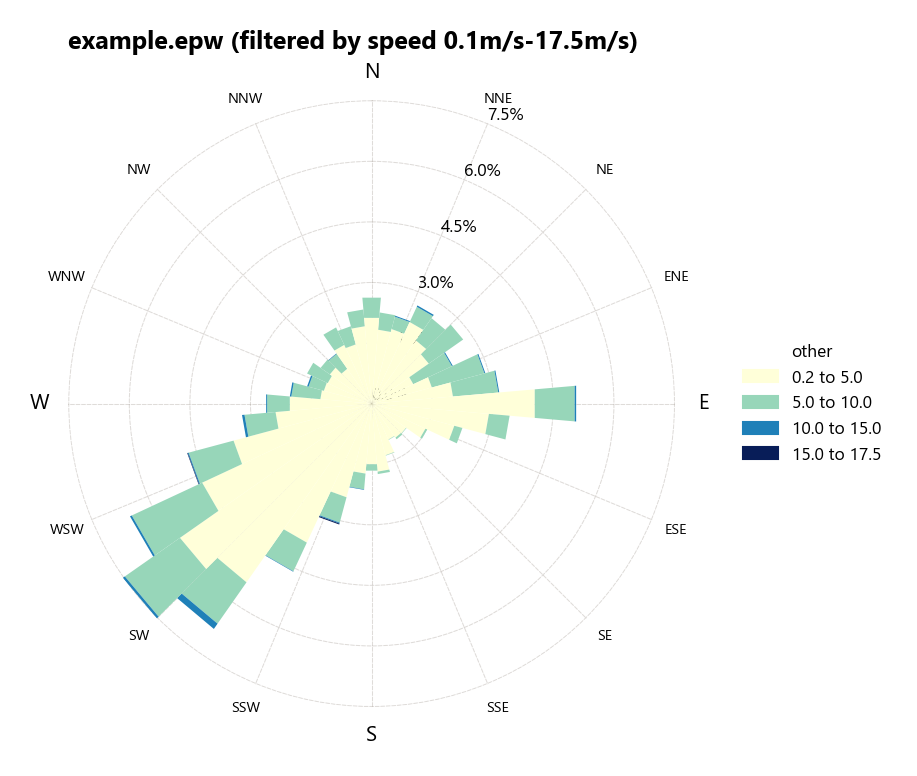

In [55]:
import scipy
from kvrrj.wind import Wind
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from collections import defaultdict

self = Wind.from_epw(epw).filter_by_speed(min_speed=0.1)
self.plot_windrose(directions=36, other_bins=[0, 5, 10, 15, 20])

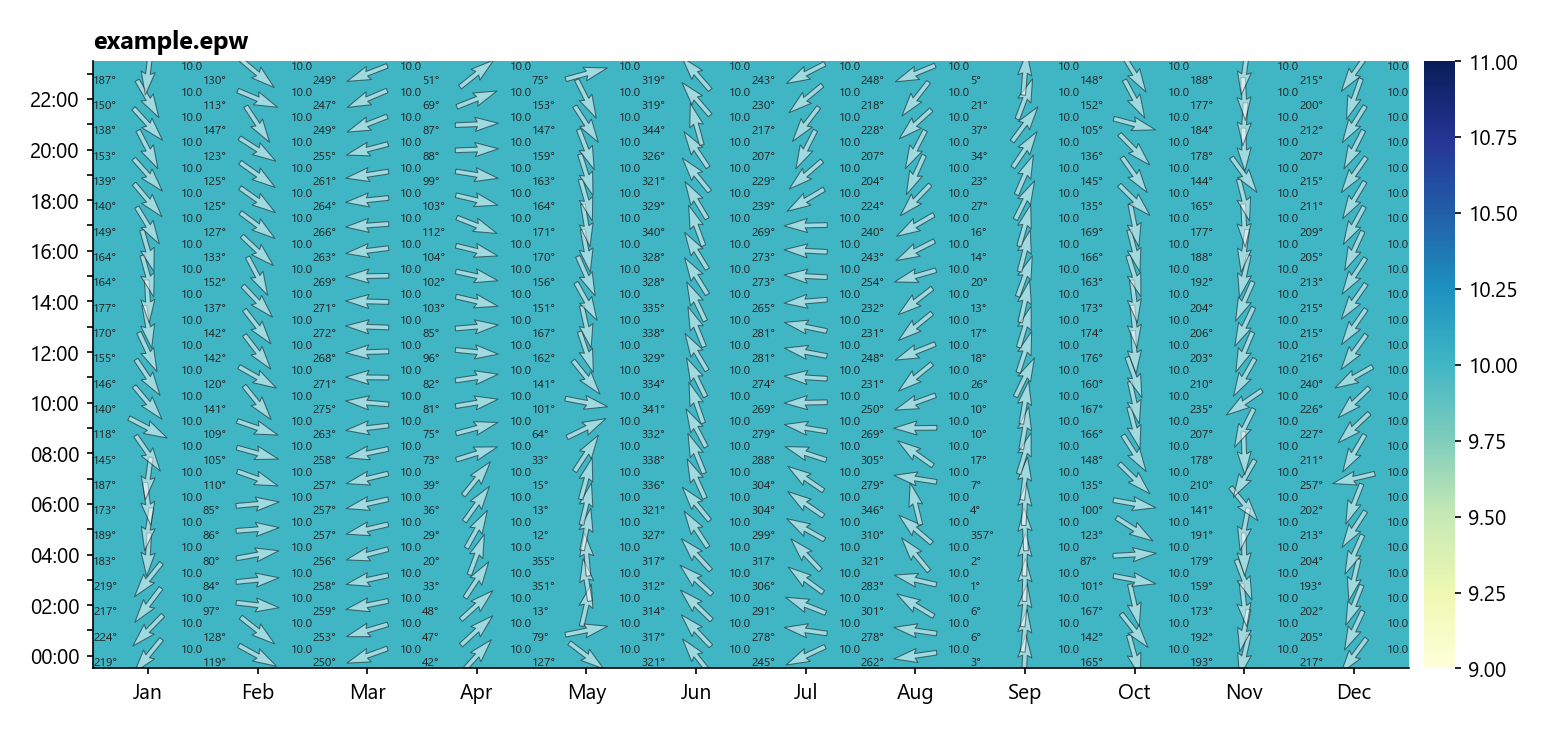

In [36]:
import calendar
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.axes import Axes

from kvrrj.geometry.util import angle_to_vector
from kvrrj.viz.color import contrasting_color

ax: Axes = None
show_values: bool = True
show_arrows: bool = True
other_data: list[float] = [10] * len(self)
kwargs = {}

"""Create a plot showing the annual wind speed and direction bins
using the month_time_average method.

Args:
    ax (plt.Axes, optional):
        The axes to plot on. If None, the current axes will be used.
    show_values (bool, optional):
        Whether to show values in the cells. Defaults to False.
    show_arrows (bool, optional):
        Whether to show the directional arrows on each patch.
    other_data: (pd.Series, optional):
        The other data to align with the wind direction and speed.
        Defaults to None which uses wind speed.
    **kwargs:
        Additional keyword arguments to pass to the pcolor function.
        title (str, optional):
            A title for the plot. Defaults to None.

Returns:
    plt.Axes:
        A matplotlib Axes object.

"""

if ax is None:
    ax = plt.gca()

if other_data is None:
    other_data = self.wind_speeds
    kwargs["vmin"] = kwargs.get("vmin", 0)
    kwargs["unit"] = kwargs.get("unit", "m/s")


ax.set_title(self.source)

df = self.wind_matrix(other_data=other_data)
_wind_directions = df["direction"]
_other_data = df["other"]

cmap = kwargs.pop("cmap", "YlGnBu")
vmin = kwargs.pop("vmin", _other_data.values.min())
vmax = kwargs.pop("vmax", _other_data.values.max())
unit = kwargs.pop("unit", "")
cbar_title = kwargs.pop("cbar_title", None)
norm = kwargs.pop("norm", plt.Normalize(vmin=vmin, vmax=vmax, clip=True))
mapper = kwargs.pop("mapper", ScalarMappable(norm=norm, cmap=cmap))
pc = ax.pcolor(_other_data, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)

if show_arrows:
    _x, _y = np.array(angle_to_vector(_wind_directions.values))
    arrow_scale = 0.8
    ax.quiver(
        np.arange(1, 13, 1) - 0.5,
        np.arange(0, 24, 1) + 0.5,
        (_x * _other_data.values / 2) * arrow_scale,
        (_y * _other_data.values / 2) * arrow_scale,
        pivot="mid",
        fc="white",
        ec="black",
        lw=0.5,
        alpha=0.5,
    )

if show_values:
    for _xx, col in enumerate(_wind_directions.values.T):
        for _yy, wind_dir_value in enumerate(col.T):
            local_value = _other_data.values[_yy, _xx]
            cell_color = mapper.to_rgba(local_value)
            text_color = contrasting_color(cell_color)
            # direction text
            ax.text(
                _xx,
                _yy,
                f"{_wind_directions.values[_yy][_xx]:0.0f}°",
                color=text_color,
                ha="left",
                va="bottom",
                fontsize="xx-small",
            )
            # other_data text
            ax.text(
                _xx + 1,
                _yy + 1,
                f"{_other_data.values[_yy][_xx]:0.1f}{unit}",
                color=text_color,
                ha="right",
                va="top",
                fontsize="xx-small",
            )

# add colorbar
ax.set_xticks([i  - 0.5 for i in range(1, 13, 1)])
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13, 1)])
ax.set_yticks([i + 0.5 for i in range(24)])
ax.set_yticklabels([f"{i:02d}:00" for i in range(24)])
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

cb = plt.colorbar(pc, label=cbar_title, pad=0.01)
cb.outline.set_visible(False)

In [ ]:

    ax.set_xticks(np.arange(1, 13, 1) - 0.5)
    ax.set_xticklabels([calendar.month_abbr[i] for i in np.arange(1, 13, 1)])
    ax.set_yticks(np.arange(0, 24, 1) + 0.5)
    ax.set_yticklabels([f"{i:02d}:00" for i in np.arange(0, 24, 1)])
    for label in ax.yaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    cb = plt.colorbar(pc, label=cbar_title, pad=0.01)
    cb.outline.set_visible(False)

    return ax